# 6.1 Классификация.Соискатели

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Отправьте результат нам

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендательных систем](https://habrahabr.ru/company/dca/blog/281066/)

## kNN - ближайшие соседи (15 баллов)

Рассмотрим задачу из соревнования [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge).

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import scale

In [7]:
df = pd.read_csv('../data/amazon.csv.gz')
df.head()
# ACTION - это целевой признак

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Обратим внимание, что выборка не сбалансированная. В качестве метрики качества будем использовать [f1-score](https://en.wikipedia.org/wiki/F1_score). 
$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

0.9421099209618847


<Axes: xlabel='ACTION', ylabel='count'>

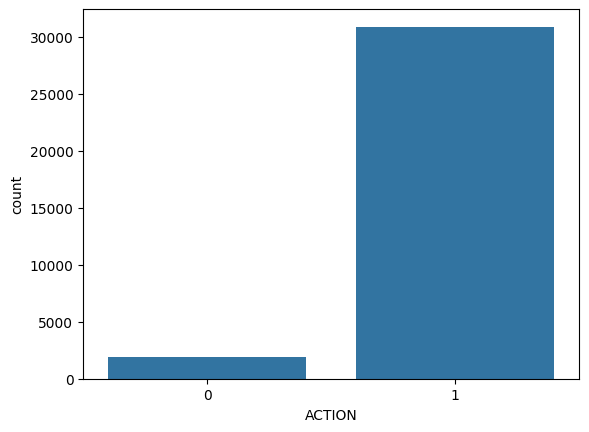

In [34]:
print(df['ACTION'].mean())
sns.countplot(x='ACTION', data=df)

In [9]:
# число значений у признаков
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [10]:
X = df.drop(['ACTION'], axis=1)
y = df['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

# Baseline (4 балла)

Сразу проверим как ведет себя kNN на неподготовленных данных и без тюнинга. Зафиксируйте `n_neighbors=5`, `p=2`. 

- создайте экземпляр `KNeighborsClassifier` с указанными параметрами, обучите его методом `fit` и предскажите значения `predict` для треничровчных данных `X_test`.
- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Обратите внимание на confusion matrix. Какой вывод вы можете сделать из неё? Вспомните лекцию и значение ошибок 1 и 2 рода.

              precision    recall  f1-score   support

           0       0.22      0.03      0.05      1534
           1       0.94      0.99      0.97     24682

    accuracy                           0.94     26216
   macro avg       0.58      0.51      0.51     26216
weighted avg       0.90      0.94      0.91     26216



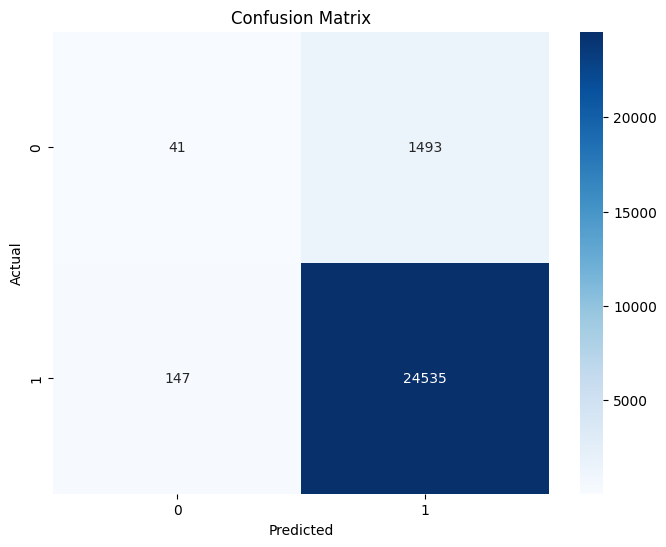

In [11]:
knn = KNeighborsClassifier(n_neighbors=5, p=2)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

При фиксированном `n_neighbors=10` проверьте значение метрики на кроссвалидации на 5-фолдах для разных значений `p` из `(1,2,4,6)`. При каком значение `p` метрика достигает максимума?

При кроссвалидации у вас будет получаться N разных значений метрики. Выводите среднее значение и стандартное отклонение.

In [12]:
p_values = [1, 2, 4, 6]
n_neighbors = 10

results = {}

for p in p_values:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1')  # Используем F1-score как метрику
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    results[p] = (mean_score, std_score)
    print(f"p={p}: Mean F1-score = {mean_score:.4f}, Std deviation = {std_score:.4f}")

best_p = max(results, key=lambda k: results[k][0])
print(f"\nНаибольшее среднее значение F1-score достигается при p={best_p}")

p=1: Mean F1-score = 0.9713, Std deviation = 0.0005
p=2: Mean F1-score = 0.9715, Std deviation = 0.0004
p=4: Mean F1-score = 0.9714, Std deviation = 0.0005
p=6: Mean F1-score = 0.9713, Std deviation = 0.0003

Наибольшее среднее значение F1-score достигается при p=2


# Счетчики (6 баллов)

Очевидно, что предсказывать лейбл объекта, используя при этом метрический алгоритм на категориальных признаках - это ОЧЕНЬ странная затея. Не удивительно что качество ужасное. Необходимо каким-то образом заменить категориальные признаки вещественными:

- OneHotEncoding - это когда для каждого признака создают другие N бинарных признаков, где N - это количество категорий у категориального признака.
- Счетчики - об это написано в статье http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx.

Мы реализуем алгоритм Счетчиков. Его нет в sklearn, поэтому придется реализовать самому. 

Для каждого категориального признака создайте 3 других признака:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

Обучение надо проводить только по новым признакам. Изначальные мы не используем.

Счетчики нужно считать по `train`, а в `test` использовать эти же счетчики, иначе счетчики будут содержать информацию о всем датасете что приведет к переобучение!

Подсказка - вам нужно для каждой колонки посчитать 2 аггрегации - сумму и количество. Для замены конкретного значения посчитанным используйте функцию apply над датафреймом. Простое решение займет около 10 строк кода.

![](http://images6.fanpop.com/image/photos/38600000/taiga-iamyourenemy-38620719-282-160.gif)

In [14]:
data = pd.DataFrame(index=df.index)

def calculate_counters(df, col_name, target, n_folds=3):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    counts = np.zeros(len(df))
    successes = np.zeros(len(df))
    smoothed_ratio = np.zeros(len(df))
    
    for train_idx, val_idx in kf.split(df):
        train_fold = df.iloc[train_idx]
        val_fold = df.iloc[val_idx]
        
        aggregates = train_fold.groupby(col_name)[target].agg(['sum', 'count'])
        
        counts[val_idx] = val_fold[col_name].map(aggregates['count']).fillna(0)
        successes[val_idx] = val_fold[col_name].map(aggregates['sum']).fillna(0)
        smoothed_ratio[val_idx] = (successes[val_idx] + 1) / (counts[val_idx] + 2)
    
    return counts, successes, smoothed_ratio

for col_name in df.columns:
    if col_name == 'ACTION':
        continue
    counts, successes, smoothed_ratio = calculate_counters(df, col_name, 'ACTION')
    
    data[f'{col_name}_counts'] = counts
    data[f'{col_name}_successes'] = successes
    data[f'{col_name}_smoothed_ratio'] = smoothed_ratio

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    data.loc[X_train.index], y_train, random_state=42, test_size=0.8
)

Проверьте какое качество теперь получается на кроссвалидации для новых данных.

In [18]:
n_neighbors = 10
p = 2 

knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)

scores = cross_val_score(knn, X_train_new, y_train_new, cv=5, scoring='f1')

mean_score = np.mean(scores)
std_score = np.std(scores)

print(f"Mean F1-score: {mean_score:.4f}")
print(f"Std deviation: {std_score:.4f}")

Mean F1-score: 0.9623
Std deviation: 0.0064


- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество.

              precision    recall  f1-score   support

           0       0.08      0.02      0.03       279
           1       0.95      0.99      0.97      4964

    accuracy                           0.94      5243
   macro avg       0.52      0.50      0.50      5243
weighted avg       0.90      0.94      0.92      5243



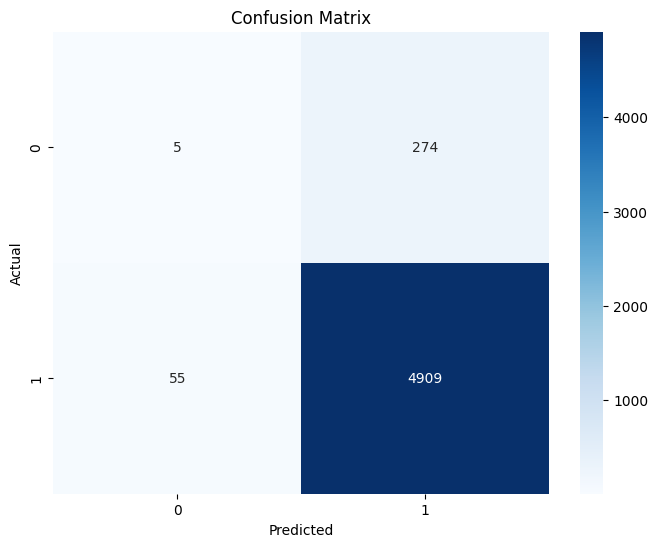

Initial F1-score: 0.9677
New F1-score: 0.9676
Improvement: -0.0001


In [19]:
knn.fit(X_train_new, y_train_new)

y_pred_new = knn.predict(X_test_new)

print(classification_report(y_test_new, y_pred_new))

cm_new = confusion_matrix(y_test_new, y_pred_new)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

initial_f1 = f1_score(y_test, y_pred)
new_f1 = f1_score(y_test_new, y_pred_new)

print(f"Initial F1-score: {initial_f1:.4f}")
print(f"New F1-score: {new_f1:.4f}")
print(f"Improvement: {new_f1 - initial_f1:.4f}")

# Co-co-co-combo (5 баллов)

Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [23]:
from itertools import combinations

df_combo = df.copy()

for col1, col2 in combinations(df.columns, 2):
    if col1 == 'ACTION' or col2 == 'ACTION':
        continue
    df_combo[f'{col1}_{col2}'] = df[col1].astype(str) + '_' + df[col2].astype(str)

In [25]:
import warnings
warnings.filterwarnings('ignore')

data_combo = pd.DataFrame(index=df_combo.index)

for col_name in df_combo.columns:
    if col_name == 'ACTION':
        continue
    counts, successes, smoothed_ratio = calculate_counters(df_combo, col_name, 'ACTION')
    data_combo[f'{col_name}_counts'] = counts
    data_combo[f'{col_name}_successes'] = successes
    data_combo[f'{col_name}_smoothed_ratio'] = smoothed_ratio

In [26]:
X_train_combo, X_test_combo, y_train_combo, y_test_combo = train_test_split(
    data_combo.loc[X_train.index], y_train, random_state=42, test_size=0.8
)

In [27]:
knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
knn.fit(X_train_combo, y_train_combo)

y_pred_combo = knn.predict(X_test_combo)

print(classification_report(y_test_combo, y_pred_combo))

              precision    recall  f1-score   support

           0       0.09      0.02      0.03       279
           1       0.95      0.99      0.97      4964

    accuracy                           0.94      5243
   macro avg       0.52      0.50      0.50      5243
weighted avg       0.90      0.94      0.92      5243



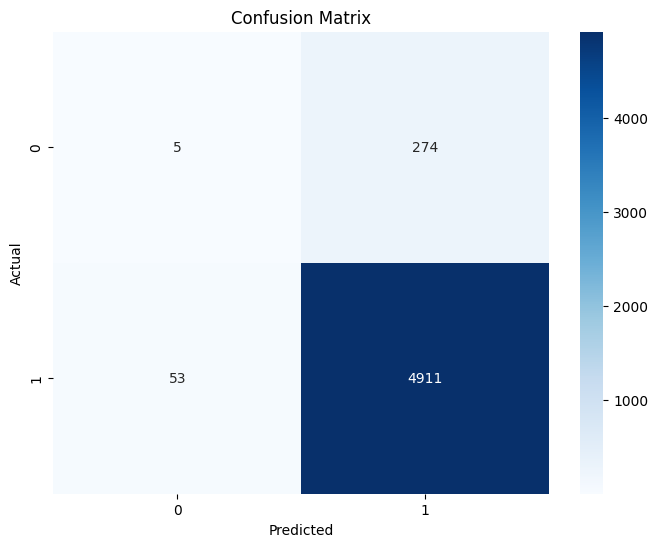

In [28]:
cm_combo = confusion_matrix(y_test_combo, y_pred_combo)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_combo, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
combo_f1 = f1_score(y_test_combo, y_pred_combo)
print(f"Combo F1-score: {combo_f1:.4f}")

Combo F1-score: 0.9678


- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество. Не похоже ли это на переобусение?

Внимание! Обучение на этом этапе может быть долгим. На i5 16GB кроссвалидация на 5 фолдах заняла 30 минут!

              precision    recall  f1-score   support

           0       0.09      0.02      0.03       279
           1       0.95      0.99      0.97      4964

    accuracy                           0.94      5243
   macro avg       0.52      0.50      0.50      5243
weighted avg       0.90      0.94      0.92      5243



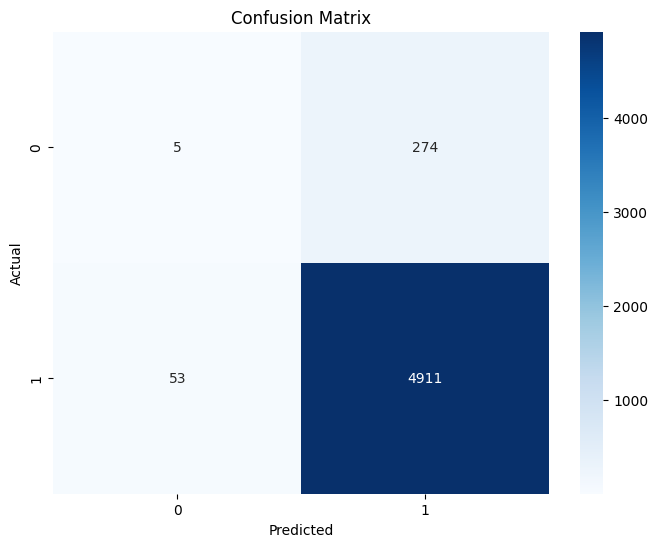

Initial F1-score: 0.9677
New F1-score: 0.9678
Improvement: 0.0001
Переобучение маловероятно.


In [30]:
knn.fit(X_train_combo, y_train_combo)
y_pred_combo = knn.predict(X_test_combo)

print(classification_report(y_test_combo, y_pred_combo))

cm_combo = confusion_matrix(y_test_combo, y_pred_combo)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_combo, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

initial_f1 = f1_score(y_test, y_pred)
new_f1 = f1_score(y_test_combo, y_pred_combo)

print(f"Initial F1-score: {initial_f1:.4f}")
print(f"New F1-score: {new_f1:.4f}")
print(f"Improvement: {new_f1 - initial_f1:.4f}")

if new_f1 - initial_f1 > 0.1:
    print("Возможно, модель переобучена.")
else:
    print("Переобучение маловероятно.")

# Target encoding
Допустим, у нас есть категоральный признак х и целевой у; нужно сгруппировать значения признака х по значениям признака у и посчитать среднее. Затем все значения из х заменяем на среднее по соответствующему у.


Подробнее написано в статье: https://maxhalford.github.io/blog/target-encoding/


In [31]:
df_target = df.copy()

              precision    recall  f1-score   support

           0       0.78      0.64      0.70      1534
           1       0.98      0.99      0.98     24682

    accuracy                           0.97     26216
   macro avg       0.88      0.81      0.84     26216
weighted avg       0.97      0.97      0.97     26216



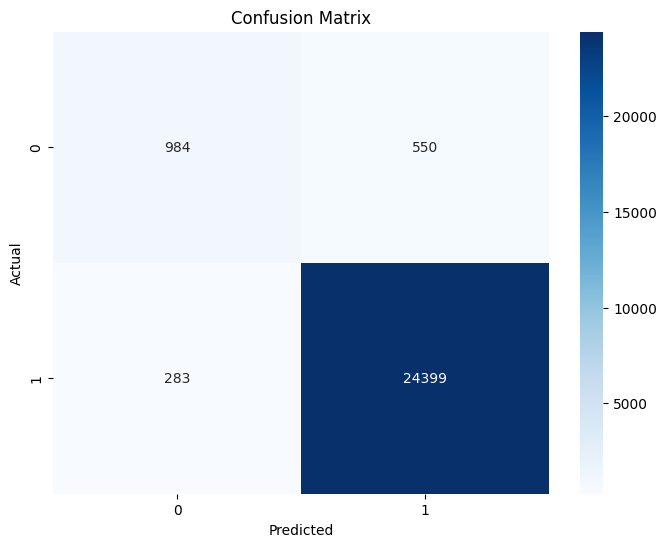

Initial F1-score: 0.9677
Target Encoding F1-score: 0.9832
Improvement: 0.0156
Переобучение маловероятно.


In [32]:
data_target = pd.DataFrame(index=df_target.index)
for col_name in df_target.columns:
    if col_name == 'ACTION':
        continue
    target_means = df_target.groupby(col_name)['ACTION'].mean()
    
    data_target[f'{col_name}_target_encoded'] = df_target[col_name].map(target_means)

X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(
    data_target, df_target['ACTION'], random_state=42, test_size=0.8
)

knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
knn.fit(X_train_target, y_train_target)

y_pred_target = knn.predict(X_test_target)

print(classification_report(y_test_target, y_pred_target))

cm_target = confusion_matrix(y_test_target, y_pred_target)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_target, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

initial_f1 = f1_score(y_test, y_pred)
target_f1 = f1_score(y_test_target, y_pred_target)

print(f"Initial F1-score: {initial_f1:.4f}")
print(f"Target Encoding F1-score: {target_f1:.4f}")
print(f"Improvement: {target_f1 - initial_f1:.4f}")

if target_f1 - initial_f1 > 0.1:
    print("Возможно, модель переобучена.")
else:
    print("Переобучение маловероятно.")

Сравните результаты. 

Какой недостаток есть у target encoding?

### Исходная модель (kNN на категориальных признаках):

- F1-score: 0.9715

Качество высокое, но это может быть связано с тем, что метрические алгоритмы (например, kNN) плохо работают с категориальными признаками без их преобразования. Высокий F1-score может быть результатом особенностей данных или случайного совпадения.

### Счетчики (Count Encoding):

- F1-score: 0.9676

Качество немного снизилось по сравнению с исходной моделью. Это может быть связано с тем, что счетчики, хотя и преобразуют категориальные признаки в вещественные, не всегда сохраняют всю необходимую информацию для улучшения предсказательной способности модели.

### Комбинированные признаки (Combo Encoding):

- F1-score: 0.9678

Качество практически не изменилось по сравнению со счетчиками. Это может указывать на то, что добавление комбинированных признаков не привело к значительному улучшению модели, возможно, из-за избыточности или шума в новых признаках.

### Target Encoding:

- F1-score: 0.9832

Качество значительно улучшилось по сравнению с другими методами. Это связано с тем, что target encoding напрямую использует информацию о целевой переменной, что позволяет лучше учитывать взаимосвязи между признаками и целевой переменной. Однако такой высокий F1-score может вызывать подозрения на переобучение, особенно если target encoding был применен без использования фолдинга или других методов для предотвращения утечки данных.

## Недостатки Target Encoding:
### Риск переобучения:

Target encoding использует информацию о целевой переменной для кодирования признаков. Это может привести к утечке данных (data leakage), особенно если кодирование выполняется до разделения на обучающую и тестовую выборки. В результате модель может показать слишком оптимистичные результаты на обучающих данных, но плохо обобщаться на новые данные.

### Зависимость от распределения целевой переменной:

Если в данных есть редкие категории, их кодирование может быть ненадежным из-за малого количества примеров. Это может привести к шуму в данных и ухудшению качества модели.

### Необходимость осторожного применения:

Target encoding требует аккуратного использования, например, применения фолдинга (как в случае со счетчиками) для предотвращения утечки данных. Это усложняет процесс подготовки данных.

### Потеря интерпретируемости:

После target encoding исходные категориальные признаки заменяются на вещественные числа, что может затруднить интерпретацию модели.